In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.datasets.cifar10 as cifar10
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader

**Standford dog dataset**

In [ ]:
# Install required libraries
!pip install tensorflow tensorflow-datasets matplotlib


##code with early stopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Loading the trained model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),  # Adjusted kernel size and stride
            nn.Sigmoid()  # Output range [0, 1] for image pixels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Define RMSE loss function
def rmse_loss(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

# Define a function for plotting training and validation loss
def plot_loss(train_loss, val_loss, test_loss=None):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    if test_loss is not None:
        plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.legend()
    plt.show()

100%|██████████| 170498071/170498071 [00:04<00:00, 42566026.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/20], Train Loss: 0.2035, Val Loss: 0.1530
Epoch [2/20], Train Loss: 0.1517, Val Loss: 0.1481
Epoch [3/20], Train Loss: 0.1488, Val Loss: 0.1463
Epoch [4/20], Train Loss: 0.1475, Val Loss: 0.1454
Epoch [5/20], Train Loss: 0.1467, Val Loss: 0.1447
Epoch [6/20], Train Loss: 0.1463, Val Loss: 0.1445
Epoch [7/20], Train Loss: 0.1459, Val Loss: 0.1441
Epoch [8/20], Train Loss: 0.1455, Val Loss: 0.1435
Epoch [9/20], Train Loss: 0.1453, Val Loss: 0.1433
Epoch [10/20], Train Loss: 0.1451, Val Loss: 0.1435
Epoch [11/20], Train Loss: 0.1450, Val Loss: 0.1433
Epoch [12/20], Train Loss: 0.1449, Val Loss: 0.1430
Epoch [13/20], Train Loss: 0.1448, Val Loss: 0.1427
Epoch [14/20], Train Loss: 0.1447, Val Loss: 0.1430
Epoch [15/20], Train Loss: 0.1445, Val Loss: 0.1432
Epoch [16/20], Train Loss: 0.1445, Val Loss: 0.1426
Epoch [17/20], Train Loss: 0.1443, Val Loss: 0.1426
Epoch [18/20], Train Loss: 0.1443, V

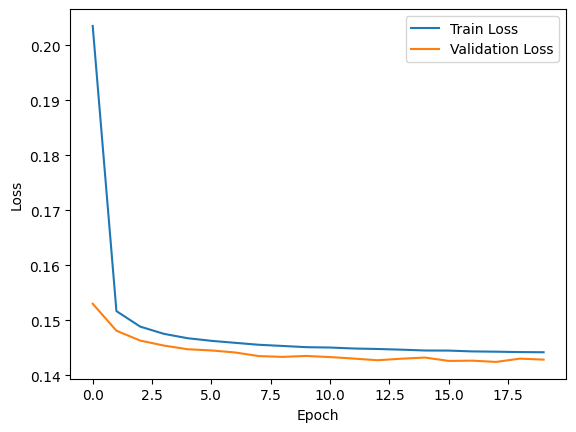

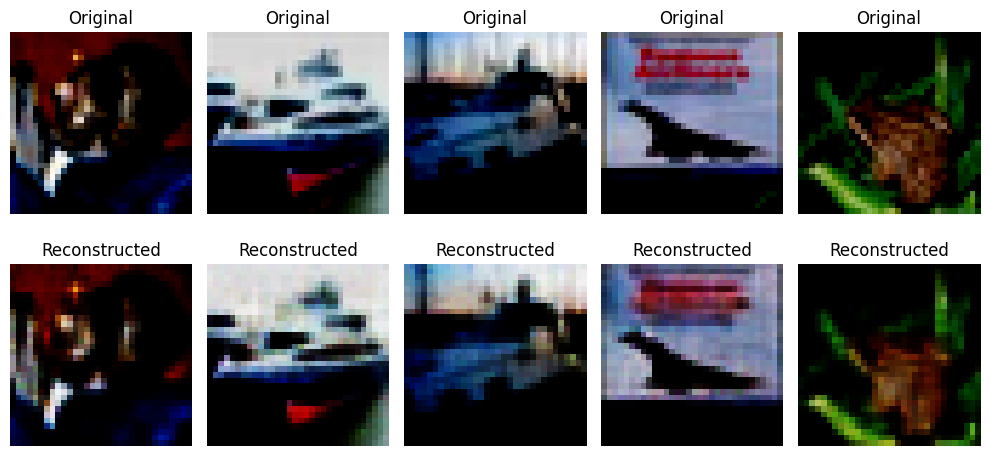

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms without augmentation for training
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

# Define data transforms for testing (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training set into training and validation sets
# Using a 80-20 split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Initialize the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop with early stopping
num_epochs = 20
patience = 5  # Number of epochs to wait before early stopping if validation loss doesn't improve
min_val_loss = float('inf')
no_improvement_counter = 0

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1
        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}...')
            break

torch.save(model.state_dict(), 'autoencoder_model_with_Aug.pth')


# Plotting loss curves
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize original and reconstructed images
model.eval()
with torch.no_grad():
    inputs, _ = next(iter(test_loader))
    inputs = inputs.to(device)
    outputs = model(inputs)
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    plt.figure(figsize=(10, 5))
    num_images_to_show = 5
    for i in range(num_images_to_show):
        plt.subplot(2, num_images_to_show, i + 1)
        plt.imshow(np.transpose(inputs[i], (1, 2, 0)))
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
        plt.imshow(np.transpose(outputs[i], (1, 2, 0)))
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Initialize the model with the same architecture
model = Autoencoder()

# Load the saved parameters into the model (map to CPU)
model.load_state_dict(torch.load('/content/autoencoder_model_with_Aug.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): C

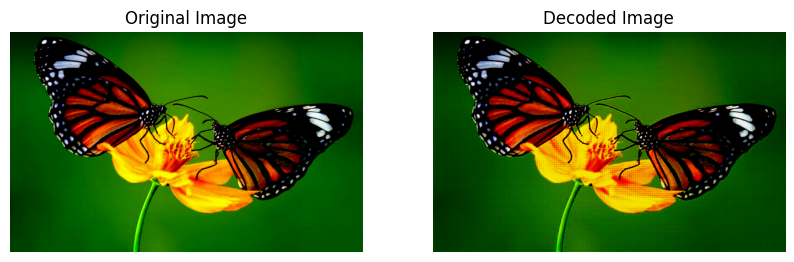

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image file
image_path = "/content/image2.jpg"

# Open the image using PIL
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

# Convert the image to a torch tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_tensor = transform(image_np).unsqueeze(0)

# Define a function to encode and decode the image
def encode_decode_image(image_tensor):
    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    return decoded_image_np

# Encode and decode the image
encoded_decoded_image = encode_decode_image(image_tensor)

#
def display_images(original_image, decoded_image):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Original Image')
    plt.axis('off')

    # Plot decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Decoded Image')
    plt.axis('off')

    plt.show()

# Display the original image and decoded image side by side
display_images(image_tensor, torch.tensor(encoded_decoded_image))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),  # Adjusted kernel size and stride
            nn.Sigmoid()  # Output range [0, 1] for image pixels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Initialize the model with the same architecture
model = Autoencoder()

# Load the saved parameters into the model (map to CPU)
model.load_state_dict(torch.load('/content/autoencoder_model_with_Aug.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): C

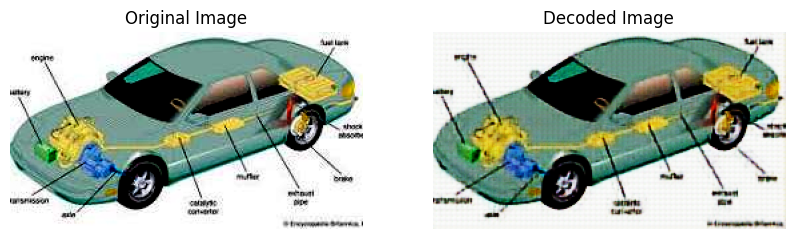

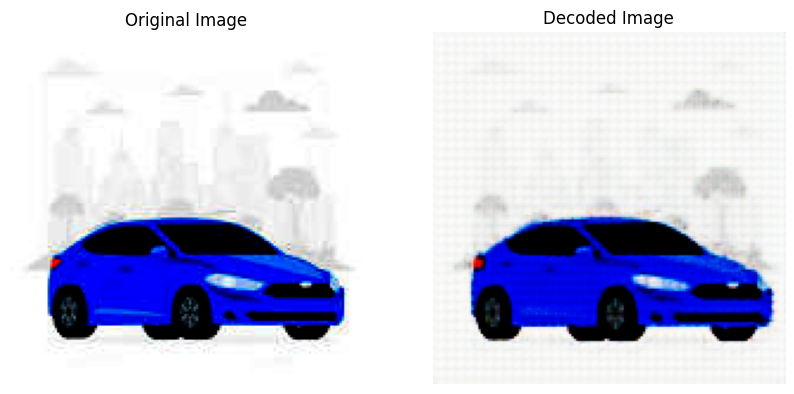

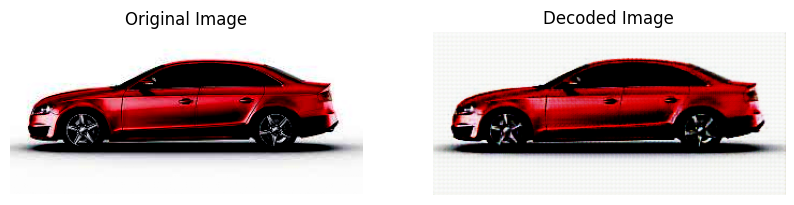

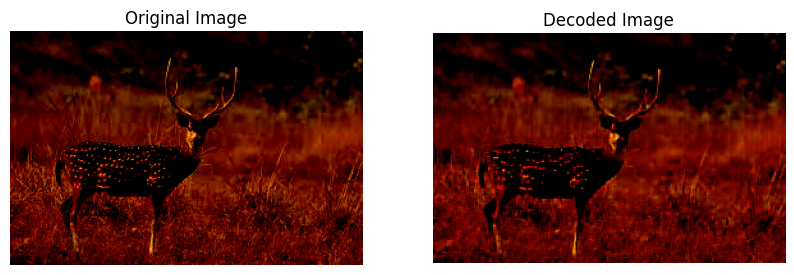

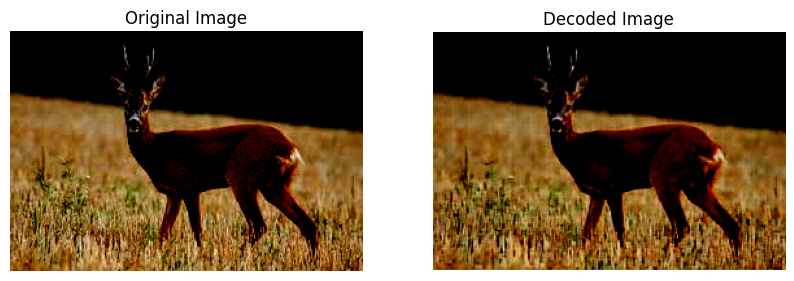

In [ ]:
# Path to the image files
image_paths = ["/content/automobile1.jpeg", "/content/automobile2.jpeg", "/content/automobile3.jpeg","/content/deer1.jpeg","/content/deer3.jpeg"]

# Open and process each image
for image_path in image_paths:
    # Open the image using PIL
    image = Image.open(image_path)

    # Convert the image to a numpy array
    image_np = np.array(image)

    # Convert the image to a torch tensor and normalize it
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image_tensor = transform(image_np).unsqueeze(0)

    # Define a function to encode and decode the image
    def encode_decode_image(image_tensor):
        # Encode the image
        encoded_image = model.encoder(image_tensor)

        # Decode the encoded image
        decoded_image = model.decoder(encoded_image)

        # Convert the decoded image tensor back to numpy array
        decoded_image_np = decoded_image.squeeze(0).detach().numpy()

        return decoded_image_np

    # Encode and decode the image
    encoded_decoded_image = encode_decode_image(image_tensor)

    # Function to display images
    def display_images(original_image, decoded_image):
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
        plt.title('Original Image')
        plt.axis('off')

        # Plot decoded image
        plt.subplot(1, 2, 2)
        plt.imshow(decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
        plt.title('Decoded Image')
        plt.axis('off')

        plt.show()

    # Display the original image and decoded image side by side
    display_images(image_tensor, torch.tensor(encoded_decoded_image))
